In [22]:
import pandas as pd
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt
from tqdm import tqdm

PROCESSED_ANNOTATIONS_PATH = "../../../data/processed_observations.csv"
COLLISIONS_HEATMAP_OUTPUT_PATH = "../../../data_out/collisions.pickle"

ID = 'Id'
BEHAVIOR = 'Behavior'
START = 'Start (s)'
STOP = 'Stop (s)'
DURATION = 'Duration (s)'
LECTURE_ID = "lecture_id"
VIDEO = 'Video'
BEHAVIOR_ID = 'BehaviorId'

COLUMN_TYPES = {
    ID: int,
    BEHAVIOR: str,
    BEHAVIOR_ID: int,
    START: np.float,
    STOP: np.float,
    DURATION: np.float,
    VIDEO: str
}

B_WRITING = 1
B_CHARTS_S = 7
B_CHARTS_P = 8
B_IMAGES_S = 13
B_IMAGES_P = 14
B_WEBSITE_S = 15
B_WEBSITE_P = 16
B_FILMS_S = 22
B_FILMS_P = 23

REL_BEH = [
    B_WRITING,
    B_CHARTS_S,
    B_CHARTS_P,
    B_IMAGES_S,
    B_IMAGES_P,
    B_WEBSITE_S,
    B_WEBSITE_P,
    B_FILMS_S,
    B_FILMS_P
]

state_behaviors = [
    B_WRITING,
    B_CHARTS_S,
    B_IMAGES_S,
    B_WEBSITE_S,
    B_FILMS_S
]

BEH_IDS = {
    'eye contact': 0,
    'Writing on slides': 1,
    'use of voice intonation to Emphasise more important issues/topics': 2,
    'S, Asking questions': 3,
    'P, Asking questions': 4,
    'S, giving questions to students: rhetorical, comprehension questions': 5,
    'P, giving questions to students: rhetorical, comprehension questions", point each question': 6,
    'S, cHarts in slides': 7,
    'P, cHarts in slides': 8,
    'S, organization: giving class outline, clearly indicating Transition from one topic to another': 9,
    'P, organization: giving class outline, clearly indicating Transition from one topic to another"': 10,
    'Laughter': 11,
    'demonstration': 12,
    'S, Images in slides': 13,
    'P, Images in slides': 14,
    'S, website': 15,
    'P, website': 16,
    'Active teacher stands by slides and explains them': 17,
    'Movement across podium': 18,
    'Writing on a whiteboard': 19,
    'summing Up': 20,
    'discipline': 21,
    'S, Films or animations in slides': 22,
    'P, Films or animations in slides': 23,
    'assignments': 24,
    'S, students are asking questions, generating their own ideas': 25,
    'P, students are asking questions, generating their own ideas': 26,
    'S, giving hints how to do something': 27,
    'P, giving hints how to do something': 28,
    'S, Referring to bibliography, other researchers': 29,
    'P, Referring to bibliography, other researchers': 30,
    'S, Session on tests': 31,
    'P, Session on tests': 32,
    "students' Disscusion": 33
}
BEH_DESC_BY_ID = {v: k for k, v in BEH_IDS.items()}



### Import annotations

In [14]:
annotations_df = pd.read_csv(PROCESSED_ANNOTATIONS_PATH, dtype=COLUMN_TYPES)
annotations_df = annotations_df[annotations_df[BEHAVIOR_ID].isin(REL_BEH)]

### Analyze behavior collisions

In [15]:
beh_pairs = []
for beh1 in state_behaviors:
    for beh2 in state_behaviors:
        if beh1 == beh2:
            continue
        beh_pairs.append((beh1, beh2))
beh_pairs

[(1, 7),
 (1, 13),
 (1, 15),
 (1, 22),
 (7, 1),
 (7, 13),
 (7, 15),
 (7, 22),
 (13, 1),
 (13, 7),
 (13, 15),
 (13, 22),
 (15, 1),
 (15, 7),
 (15, 13),
 (15, 22),
 (22, 1),
 (22, 7),
 (22, 13),
 (22, 15)]

In [16]:
class CollisionsData:
    
    def __init__(self, beh_pair, beh1_count, collisions_count, collisions_on_average):
        self.beh_pair = beh_pair
        self.beh1_count = beh1_count
        self.collisions_count = collisions_count
        self.collisions_on_average = collisions_on_average
    
    def __repr__(self):
        return f"{self.beh_pair}, {self.beh1_count}, {self.collisions_count}, {self.collisions_on_average}"

In [17]:
def save_heatmap(heatmap_data):
    with open(COLLISIONS_HEATMAP_OUTPUT_PATH, 'wb') as f:
        pickle.dump(heatmap_data, f, pickle.HIGHEST_PROTOCOL)


def try_read_heatmap():
    if os.path.exists(COLLISIONS_HEATMAP_OUTPUT_PATH):
        with open(COLLISIONS_HEATMAP_OUTPUT_PATH, 'rb') as f:
            data = pickle.load(f)
            return data
    return None

In [25]:
def calculate_heatmap_data():
    maybe_data = try_read_heatmap()
    if maybe_data:
        return maybe_data

    videos_collisions_data_by_pair = dict()
    for pair in beh_pairs:
        videos_collisions_data_by_pair[pair] = []

    videos_set = annotations_df[VIDEO].unique()

    for video in tqdm(videos_set):

        for pair in beh_pairs:

            beh_1 = pair[0]
            beh_2 = pair[1]

            beh_1_df = annotations_df[(annotations_df[VIDEO] == video) & (annotations_df[BEHAVIOR_ID] == beh_1)]
            beh_2_df = annotations_df[(annotations_df[VIDEO] == video) & (annotations_df[BEHAVIOR_ID] == beh_2)]

            beh_1_count = len(beh_1_df)
            beh_1_coll_count = 0
            for row_index1, row1 in beh_1_df.iterrows():

                start1 = row1[START]
                stop1 = row1[STOP]

                for row_index2, row2 in beh_2_df.iterrows():

                    start2 = row2[START]
                    stop2 = row2[STOP]

                    no_collision = (stop1 < start2 or start1 > stop2)
                    if not no_collision:
                        beh_1_coll_count += 1
                        break

            # ignore videos where particular behavior doesn't even exist
            if beh_1_count > 0:
                avg = beh_1_coll_count / beh_1_count
                coll_data = CollisionsData(pair, beh_1_count, beh_1_coll_count, avg)
                videos_collisions_data_by_pair[pair].append(coll_data)

    heatmap_data = []

    for beh1 in state_behaviors:
        data = []

        for beh2 in state_behaviors:
            if beh1 == beh2:
                data.append(float('nan'))
                continue

            videos_data = videos_collisions_data_by_pair[(beh1, beh2)]
            sum_of_avg = 0
            for video_data in videos_data:
                sum_of_avg += video_data.collisions_on_average

            data.append(sum_of_avg / len(videos_data))

        heatmap_data.append(data)

    save_heatmap(heatmap_data)
    return heatmap_data

In [26]:
heatmap_data = calculate_heatmap_data()

100%|██████████| 114/114 [00:57<00:00,  1.99it/s]


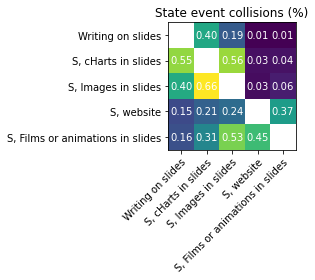

In [27]:
y_behs = state_behaviors
x_behs = state_behaviors

fig, ax = plt.subplots()
im = ax.imshow(heatmap_data)

# We want to show all ticks...
ax.set_xticks(np.arange(len(x_behs)))
ax.set_yticks(np.arange(len(y_behs)))
# ... and label them with the respective list entries
ax.set_xticklabels([BEH_DESC_BY_ID[behid] for behid in x_behs])
ax.set_yticklabels([BEH_DESC_BY_ID[behid] for behid in y_behs])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(y_behs)):
    for j in range(len(x_behs)):
        number = "{:.2f}".format(heatmap_data[i][j])
        text = ax.text(j, i, number,
                       ha="center", va="center", color="w")

ax.set_title("State event collisions (%)")
fig.tight_layout()
plt.show()